# Run evaluation on datasets and report metrics and predictions

* going forward we will use this as our standard approach to obtain metrics for a model
* currently, we are still using the default models (ie, whisper models as they are), but once we have trained our own models we will use this notebook to get the WER for the adapted models (which hopefully is much better than the current base models)

# Imports and defs

In [2]:
!nvidia-smi

Wed Aug  6 00:56:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:8C:00.0 Off |                    0 |
| N/A   40C    P0             66W /  400W |     823MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----


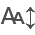

In [3]:
import datasets
from IPython.display import Audio, display

import itables
itables.init_notebook_mode()
from huggingface_hub import hf_hub_download
import numpy as np
import pandas as pd
import os

import torch
from tqdm.auto import tqdm
from transformers.pipelines.pt_utils import Dataset

In [4]:
# more efficient dataset handling
datasets.disable_caching()
print('cache:', datasets.is_caching_enabled())

torch.set_num_threads(1)
torch.get_num_threads()

cache: False


1

In [5]:
# note: this is slower when more stored in dataset (eg features), as it leads to data being copied around
class AudioTextDataset(Dataset):

    DEFAULT_UTTERANCE_FIELDS = ['audio_id', 'speaker_id',  'language', 
                         'prompt_type', 'prompt_id',
                         'transcription', 'audio_length', 'transcript_length']

    def __init__(self, dataset: Dataset, utterance_fields=DEFAULT_UTTERANCE_FIELDS):
        self.dataset = dataset
        self.utterance_fields = utterance_fields

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, i):

        result = {k: self.dataset[i][k] for k in self.utterance_fields}
        # these two fields are required for the ASR pipeline
        result['sampling_rate'] = self.dataset[i]['audio']['sampling_rate']
        result['raw'] = self.dataset[i]['audio']['array']
        return result


In [6]:
from evaluate import load as metrics_loader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

wer_metric = metrics_loader("wer")
cer_metric = metrics_loader("cer")

transcript_normalizer = BasicTextNormalizer()

def get_wer_cer(references, predictions,
                calculate_utterance_level_averaged_wer=False,
                normalize=True, verbose=True,
                ):
  # calculate_utterance_level_averaged_wer -- we first calculate the WER per
  # utterance and then average. This is not the standard way to calculate WER
  # on a corpus, but in a scenario of high WER (as for NSS) this allows to cap
  # at 1.0 on a per-utterance level.
  rs = references
  ps = predictions
  if normalize:
    pred_strs = [transcript_normalizer(x) for x in predictions]
    label_strs = [transcript_normalizer(x) for x in references]
  if calculate_utterance_level_averaged_wer:
    wers = []
    cers = []
    for pred_str, label_str in zip(pred_strs, label_strs):
      p = transcript_normalizer(pred_str)
      l = transcript_normalizer(label_str)
      wer = wer_metric.compute(predictions=[p], references=[l])
      cer = cer_metric.compute(predictions=[p], references=[l])
      wers.append(wer)
      cers.append(cer)
      if verbose:
        print(label_str, '-->', pred_str, '-->', wer, cer)
    wer = np.mean([min(1.0, x) for x in wers])
    cer = np.mean([min(1.0, x) for x in cers])
  else:
    wer =  min(1, wer_metric.compute(references=label_strs, predictions=pred_strs))
    cer =  min(1, cer_metric.compute(references=label_strs, predictions=pred_strs))

    if verbose:
      for pred_str, label_str in zip(pred_strs, label_strs):
        print(label_str, '-->', pred_str)

  return (wer, cer)

In [7]:
def prepare_results(results):
    df = pd.DataFrame(results)
    def clean_res(row):
        for f in df.columns:
            v = row[f]
            if isinstance(v, list):
                row[f] = v[0]
        return row
    df = df.apply(clean_res, axis=1)
    df['prediction'] = df['text'].str.strip() if isinstance(df['text'], str) else df['text']
   
    df['ground_truth'] = df['transcription'].str.strip() if isinstance(df['transcription'], str) else df['transcription']
    df = df.drop(columns=['text', 'transcription'])
    return df

def add_speaker_metadata(results_df, metadata_df):
    # Merge metadata with results_df on 'speaker_id'
    merged_df = results_df.merge(metadata_df, on='speaker_id', how='left')

    # Check if any speaker_id in results_df is missing in metadata_df
    missing_speakers = set(results_df['speaker_id']) - set(metadata_df['speaker_id'])
    if missing_speakers:
        print(f"Warning: Missing metadata for speakers: {missing_speakers}")

    return merged_df

def calculate_error_rates(results_df, verbose=False):

  def get_row_wer(row):
    reference = transcript_normalizer(row['ground_truth'])
    prediction = transcript_normalizer(row['prediction'])
    return get_wer_cer(references=[reference], predictions=[prediction], normalize=True, verbose=verbose)[0]

  def get_row_cer(row):
    reference = transcript_normalizer(row['ground_truth'])
    prediction = transcript_normalizer(row['prediction'])
    return get_wer_cer(references=[reference], predictions=[prediction], normalize=True, verbose=verbose)[1]




  # add normalized ground truth and prediction
  results_df['ground_truth_normalized'] = results_df['ground_truth'].apply(lambda x: transcript_normalizer(x))
  results_df['prediction_normalized'] = results_df['prediction'].apply(lambda x: transcript_normalizer(x))

  results_df['wer'] = results_df.apply(get_row_wer, axis=1)
  results_df['cer'] = results_df.apply(get_row_cer, axis=1)

  overall_wer_cer = get_wer_cer(references=results_df.ground_truth.tolist(),
                                predictions=results_df.prediction.tolist(),
                                calculate_utterance_level_averaged_wer=False,
                                normalize=True, verbose=verbose)

  avg_utterance_level_wer_cer = get_wer_cer(references=results_df.ground_truth.tolist(),
                                predictions=results_df.prediction.tolist(),
                                calculate_utterance_level_averaged_wer=True,
                                normalize=True, verbose=verbose)


  print('Overall WER (normalized):', round(overall_wer_cer[0],3))
  print('Overall CER (normalized):', round(overall_wer_cer[1],3))
  print('Avg WER (normalized):', round(avg_utterance_level_wer_cer[0],3))
  print('Avg CER (normalized):', round(avg_utterance_level_wer_cer[1],3))

  return results_df

In [8]:
def load_dataset(dataset_name, limit_to_30_seconds=True):
    """
    Load a dataset from Hugging Face Hub.
    If limit_to_30_seconds is True, will only load examples with audio length <= 30 seconds.
    """
    ds = datasets.load_dataset(dataset_name, split='test', streaming=False)
    orig_len = len(ds)
    if limit_to_30_seconds:
        ds = ds.filter(lambda example: example['audio_length'] <= 30)
        print(f"Filtered dataset from {orig_len} to {len(ds)} examples with audio length <= 30 seconds")
    return ds

def load_speaker_metadata(dataset_name):
    """
    Load speaker metadata from a dataset.
    """
    metadata_file_path = hf_hub_download(
        repo_id=dataset_name,
        filename="speaker_metadata.csv",
        repo_type="dataset"
    )
    # print(f"File downloaded to: {metadata_file_path}")

    metadata_df = pd.read_csv(metadata_file_path)
    metadata_df['severity'] = metadata_df['severity_speech_impairment'].apply(lambda x: x.split()[0].lower())

    # map severity

    fields_to_remove = ['severity_speech_impairment']
    metadata_df = metadata_df.drop(columns=fields_to_remove)

    return metadata_df

In [9]:
# because the kernel is running remotely, the file is stored remotely as well
# this code helps to download it

from IPython.display import HTML
import base64

def create_download_link(filename):
    with open(filename, 'rb') as f:
        data = base64.b64encode(f.read()).decode()
    
    html = f'<a href="data:application/octet-stream;base64,{data}" download="{filename}">📥 Download {filename}</a>'
    display(HTML(html))

# # Usage
# create_download_link(filename)

# Configs

In [1]:
WHISPER_MODEL_NAME = "openai/whisper-tiny"
# WHISPER_MODEL_NAME = "openai/whisper-small"
# WHISPER_MODEL_NAME = "openai/whisper-large-v3"

DATASET_NAME = "cdli/kenyan_english_nonstandard_speech_v0"
LANGUAGE = "en"

# DATASET_NAME = "cdli/kenyan_swahili_nonstandard_speech_v0"
# LANGUAGE = "sw"

# Load datasets

In [10]:
# need to login to Hugging Face Hub to access the datasets
# use your huggingface token (you can get that under "Access Tokens" in your HuggingFace account)

from huggingface_hub import login
HF_TOKEN = input()
login(token=HF_TOKEN)

In [11]:
metadata_df = load_speaker_metadata(DATASET_NAME)
dataset = load_dataset(DATASET_NAME, limit_to_30_seconds=True)
print(f"Loaded dataset with {len(dataset)} examples")

Filter:   0%|          | 0/1698 [00:00<?, ? examples/s]

Filtered dataset from 1698 to 1288 examples with audio length <= 30 seconds
Loaded dataset with 1288 examples


# Load model and pipeline

In [13]:
from transformers import pipeline

# Note: if handling data with more than 30 seconds, you need to set return_timestamps=True
# That will require batch size of 1 and also slow down the inference significantly due to timestamping

# Create pipeline
pipe = pipeline("automatic-speech-recognition", 
                model=WHISPER_MODEL_NAME,
                #return_timestamps=False,
                )

Device set to use cuda:0


# Run inference on dataset

In [14]:
generate_kwargs={
    "language": LANGUAGE, 
    "task": "transcribe",
    "max_length": 448, # Note: don't exceed 448 - otherwise you'll get index errors when max_length exceeds the models positional encoding limits
    "num_beams": 1,
    "do_sample": False
}    
print(f"Using model: {pipe.model.name_or_path} with language: {LANGUAGE}")
N = len(dataset)
# N = 100
print(f"Number of examples in dataset: {N}")

results = []
for out in tqdm(pipe(AudioTextDataset(dataset.take(N)), batch_size=32, generate_kwargs=generate_kwargs), total=N):
    # print(out)
    results.append(out)

Using model: openai/whisper-tiny with language: en
Number of examples in dataset: 1288


  0%|          | 0/1288 [00:00<?, ?it/s]

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


## Get overall results

In [15]:
# Finalizing results...

print("Finalizing results...")
results_df = prepare_results(results)
print("Getting speaker metadata...")
results_df = add_speaker_metadata(results_df, metadata_df)
print(f"Calculating WER and CER for {len(results_df)} examples...")
results_df = calculate_error_rates(results_df, verbose=False)

Finalizing results...
Getting speaker metadata...
Calculating WER and CER for 1288 examples...
Overall WER (normalized): 0.68
Overall CER (normalized): 0.433
Avg WER (normalized): 0.47
Avg CER (normalized): 0.29


In [16]:
max_len=120
def truncate_text(text, max_length):
    if len(str(text)) > max_length:
        return str(text)[:max_length] + "..."
    return str(text)
df_display = results_df.copy()
df_display['prediction'] = df_display['prediction'].apply(
    lambda x: truncate_text(x, max_len)
)
df_display['ground_truth'] = df_display['ground_truth'].apply(
    lambda x: truncate_text(x, max_len)
)
df_display = df_display.drop(columns=['ground_truth_normalized', 'prediction_normalized'])
itables.show(df_display.round(2))

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [17]:
filtered = dataset.filter(lambda example: example['audio_id'] == 'KES017_EN118')
example = filtered[0]


audio_data = example['audio']['array']
sample_rate = example['audio']['sampling_rate']
print('True transcript:', example['transcription'])
Audio(audio_data, rate=sample_rate)

Filter:   0%|          | 0/1288 [00:00<?, ? examples/s]

True transcript: They listened very easily and i missed a few questions


## Get aggregated results

* we aggregate on the per speaker level first, and then can further aggregate by certain aspects

In [18]:
per_speaker_agg = results_df[['speaker_id', 'severity', 'etiology', 'wer', 'cer']].groupby(['speaker_id', 'severity', 'etiology']).agg(['mean', 'count'])


In [19]:
# per-speaker results
per_speaker_agg.sort_values(by=['severity','speaker_id']).round(2)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
# per-severity results
per_speaker_agg.groupby(['severity']).agg(['mean', 'count']).round(2)


In [ ]:
# per-etiology results
per_speaker_agg.groupby(['etiology']).agg(['mean', 'count']).round(2)

# Safe Predictions

In [ ]:
LOCAL_OUTPUT_FOLDER = '/tmp/predictions'
if not os.path.exists(LOCAL_OUTPUT_FOLDER):
    os.makedirs(LOCAL_OUTPUT_FOLDER)
print('saving predictions to folder: ', LOCAL_OUTPUT_FOLDER)

output_filename = os.path.join(LOCAL_OUTPUT_FOLDER, DATASET_NAME.replace('cdli/', '') + '_' + WHISPER_MODEL_NAME.replace('openai/','') + '.tsv')
print('local output filename:', output_filename)
results_df.to_csv(output_filename, index=False, sep='\t', encoding='utf-8') 


# download locally
create_download_link(output_filename)
print("Click on this link to start download...")
